**AUTEUR** : Alioune WADE ET Cheikh Ibrahima FALL

*MASTER 1 MSDA*

**PROJET**: **Projet de Reconnaissance Faciale avec un Perceptron Multicouche (MLP)**

**Introduction**


**Objectif :**

Concevoir un modèle de reconnaissance faciale basé uniquement sur un MLP .

Les différentes de la réalisation de notre projet sont :

- Chargement des données
- Prétraitement des données
- Augmentation de données
- Entrainement et évaluation du modèle
- Optimisation avec Optuna


**Applications :**
- Déverrouillage par reconnaissance faciale
- Systèmes de surveillance
- Authentification dans les lieux sécurisés
- Réseaux sociaux pour l’identification automatique des visages


**Importation des des différentes bibliothèques**

In [6]:
import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
from torchvision.utils import make_grid
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

**Chargement et affichage des données**

In [8]:
data_path = "faces/"
# Transformation de base pour visualisation
transform_visualize = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [9]:
# Chargement des données
dataset = datasets.ImageFolder(root=data_path, transform=transform_visualize)

In [10]:
# Affichage de quelques images
def show_images(dataset, num_samples=5, classes=None):
    loader = DataLoader(dataset, batch_size=num_samples, shuffle=True)
    dataiter = iter(loader)
    images, labels = next(dataiter)
    
    # Afficher les images avec les étiquettes
    grid = make_grid(images, nrow=num_samples)
    plt.figure(figsize=(15, 15))
    plt.imshow(grid.permute(1, 2, 0))
    
    #if classes:
        #print(' '.join(f'{classes[labels[j]]:5s}' for j in range(num_samples)))
    #plt.show()

Exemples d'images du dataset:
s17   s35   s35   s24   s2   


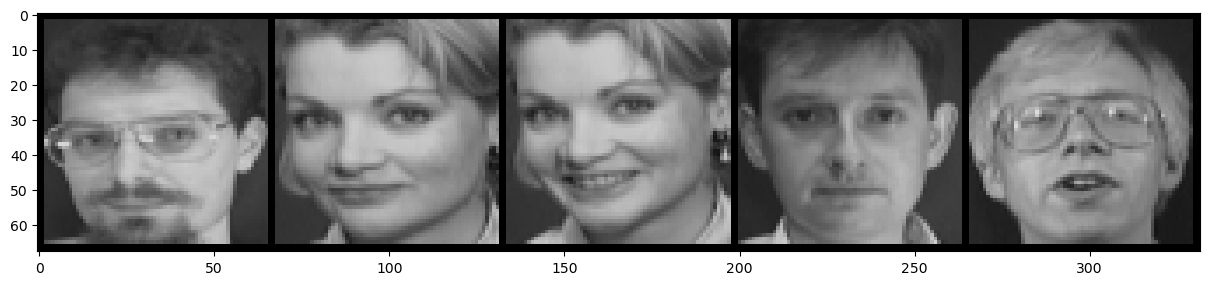

In [11]:
# Afficher quelques images 
print("Exemples d'images du dataset:")
show_images(dataset, num_samples=5, classes=dataset.classes)

**Prétraitement des données**

In [13]:
# Transformation pour le prétraitement
transform = transforms.Compose([
    transforms.Resize((64, 64)),          
    transforms.ToTensor(),                
    transforms.Normalize((0.5,), (0.5,))   # Normaliser entre 0 et 1
])

Recharger le dataset avec la nouvelle transformation

In [31]:
dataset = datasets.ImageFolder(root=data_path, transform=transform)

Séparation de notre dataset

In [36]:
train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=0.2, stratify=dataset.targets)
train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)

Création de notre DataLoader

In [39]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Vérification de la forme des images

In [42]:
data_iter = iter(train_loader)
images, labels = next(data_iter)
print(f"Forme des images après aplatissement: {images.view(images.size(0), -1).shape}")

Forme des images après aplatissement: torch.Size([32, 12288])


**Augmentation des données**

In [45]:
transform_augmented = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),  # Flip horizontal aléatoire
    transforms.RandomRotation(10),      # Rotation aléatoire de ±10 degrés
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),  # Zoom et cisaillement
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [47]:
# Dataset avec augmentation pour l'entraînement
augmented_dataset = datasets.ImageFolder(root=data_path, transform=transform_augmented)
train_dataset_augmented = Subset(augmented_dataset, train_idx)
train_loader_augmented = DataLoader(train_dataset_augmented, batch_size=batch_size, shuffle=True)

In [49]:
# Visualisation des images augmentées
def show_augmented_images(dataset, num_samples=5):
    loader = DataLoader(dataset, batch_size=num_samples, shuffle=True)
    dataiter = iter(loader)
    images, labels = next(dataiter)
    
    grid = make_grid(images, nrow=num_samples)
    plt.figure(figsize=(15, 15))
    plt.imshow(grid.permute(1, 2, 0))
    plt.title("Exemples d'images augmentées")
    plt.show()

#print("Exemples d'images après augmentation:")
#show_augmented_images(train_dataset_augmented)

**Construction du modèle**

In [82]:
class FaceRecognitionMLP(nn.Module):
    def __init__(self, input_size, hidden_size1=512, hidden_size2=256, output_size=10, dropout_rate=0.3):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.relu1 = nn.GELU()
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.relu2 = nn.GELU()
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.fc3 = nn.Linear(hidden_size2, output_size)
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.dropout1(self.relu1(self.bn1(self.fc1(x))))
        x = self.dropout2(self.relu2(self.bn2(self.fc2(x))))
        x = self.fc3(x)  # Pas de softmax ici si vous utilisez CrossEntropyLoss
        return x

# Initialisation
#model = FaceRecognitionMLP(input_size=784, output_size=10)
#criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3)

In [84]:
# Paramètres du modèle
input_size = 64 * 64 * 3  
hidden_size1 = 512
hidden_size2 = 256
output_size = len(dataset.classes)  # Nbre classes
dropout_rate = 0.5

In [86]:
# Initialisation du modèle
model = FaceRecognitionMLP(input_size, hidden_size1, hidden_size2, output_size, dropout_rate)
#print(model)

**Entrainement du modèle**

In [89]:
# Fonction de perte et optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

In [95]:
# Entraînement
num_epochs = 50
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # Mode entraînement
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader_augmented:
        # Remise à zéro des gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass et optimisation
        loss.backward()
        optimizer.step()
        
        # Calcul des statistiques
        #running_loss += loss.item()
        #_, predicted = torch.max(outputs.data, 1)
        #total += labels.size(0)
        #correct += (predicted == labels).sum().item()
    
    # Calcul de la perte et précision pour l'epoch
    train_loss = running_loss / len(train_loader_augmented)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss = val_loss / len(test_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    #print(f'Epoch [{epoch+1}/{num_epochs}], '
         # f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
         # f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

Epoch [1/50], Train Loss: 2.4729, Train Acc: 53.44%, Val Loss: 2.1149, Val Acc: 80.00%
Epoch [2/50], Train Loss: 2.5268, Train Acc: 49.38%, Val Loss: 2.1040, Val Acc: 82.50%
Epoch [3/50], Train Loss: 2.5162, Train Acc: 51.25%, Val Loss: 2.0922, Val Acc: 81.25%
Epoch [4/50], Train Loss: 2.4853, Train Acc: 50.62%, Val Loss: 2.0888, Val Acc: 82.50%
Epoch [5/50], Train Loss: 2.4308, Train Acc: 55.31%, Val Loss: 2.0793, Val Acc: 82.50%
Epoch [6/50], Train Loss: 2.4776, Train Acc: 50.94%, Val Loss: 2.0462, Val Acc: 81.25%
Epoch [7/50], Train Loss: 2.3938, Train Acc: 53.12%, Val Loss: 2.0473, Val Acc: 81.25%
Epoch [8/50], Train Loss: 2.4290, Train Acc: 53.44%, Val Loss: 2.0502, Val Acc: 81.25%
Epoch [9/50], Train Loss: 2.3736, Train Acc: 57.81%, Val Loss: 2.0391, Val Acc: 81.25%
Epoch [10/50], Train Loss: 2.3883, Train Acc: 55.94%, Val Loss: 2.0437, Val Acc: 85.00%
Epoch [11/50], Train Loss: 2.3971, Train Acc: 55.00%, Val Loss: 2.0154, Val Acc: 83.75%
Epoch [12/50], Train Loss: 2.3834, Train 

**Visualisation des courbes**

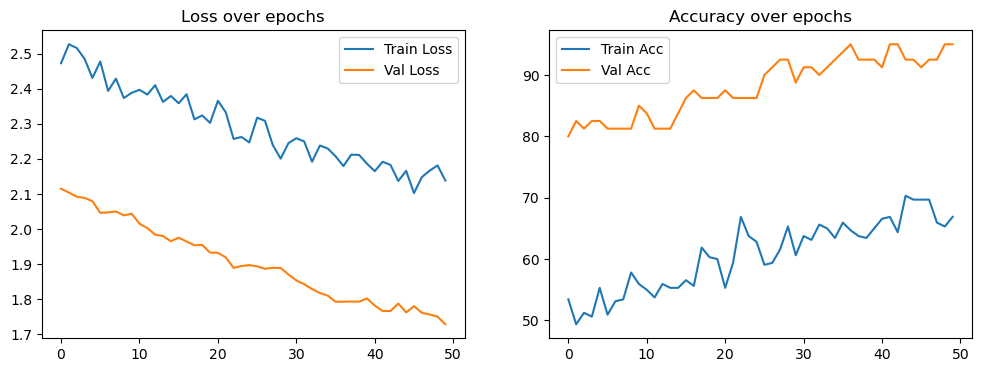

In [97]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss over epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.title('Accuracy over epochs')
plt.legend()
plt.show()

**Evaluation et Matrice de confusion**

Matrice de confusion sur l'ensemble de test:


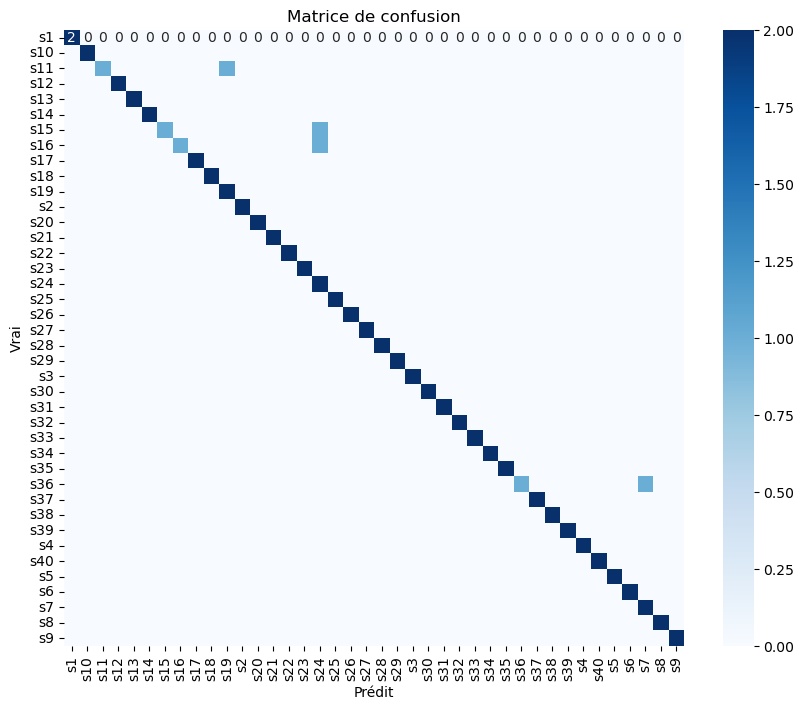

In [100]:
def plot_confusion_matrix(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in data_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=dataset.classes, 
                yticklabels=dataset.classes)
    plt.title('Matrice de confusion')
    plt.xlabel('Prédit')
    plt.ylabel('Vrai')
    plt.show()

print("Matrice de confusion sur l'ensemble de test:")
plot_confusion_matrix(model, test_loader)


**Analyse des erreurs**


Nombre total d'erreurs: 4

Exemples d'erreurs:


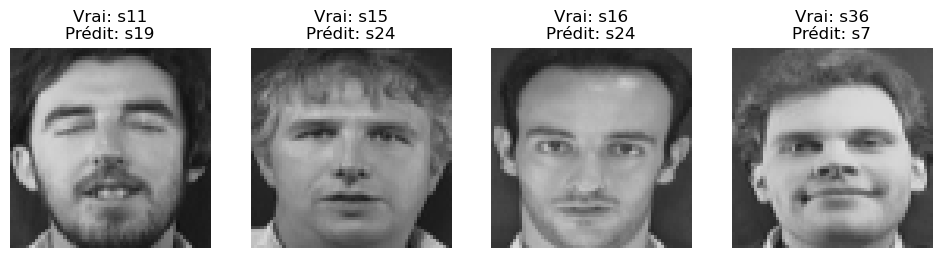

In [103]:
# Analyse des erreurs
def analyze_errors(model, data_loader, classes):
    model.eval()
    errors = []
    
    with torch.no_grad():
        for images, labels in data_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            for i in range(len(labels)):
                if predicted[i] != labels[i]:
                    errors.append({
                        'image': images[i],
                        'true': classes[labels[i]],
                        'predicted': classes[predicted[i]]
                    })
    # Afficher quelques erreurs
    print(f"\nNombre total d'erreurs: {len(errors)}")
    print("\nExemples d'erreurs:")
    
    plt.figure(figsize=(15, 10))
    for i in range(min(5, len(errors))):
        plt.subplot(1, 5, i+1)
        img = errors[i]['image'].cpu().numpy().transpose((1, 2, 0))
        img = img * 0.5 + 0.5  # Dénormaliser
        plt.imshow(img)
        plt.title(f"Vrai: {errors[i]['true']}\nPrédit: {errors[i]['predicted']}")
        plt.axis('off')
    plt.show()

analyze_errors(model, test_loader, dataset.classes)

**Optuna** : Optimisation des hyperparamètres

In [106]:
import optuna

def objective(trial):
    # Hyperparamètres à optimiser
    hidden_size1 = trial.suggest_int('hidden_size1', 256, 1024)
    hidden_size2 = trial.suggest_int('hidden_size2', 128, 512)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.6)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    
    # Création du modèle
    model = FaceRecognitionMLP(input_size, hidden_size1, hidden_size2, output_size, dropout_rate)
    
    # Optimiseur et fonction de perte
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Entraînement simplifié pour l'optimisation
    num_epochs = 10
    best_val_accuracy = 0
    
    for epoch in range(num_epochs):
        # Entraînement
        model.train()
        for images, labels in train_loader_augmented:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_accuracy = correct / total
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
    
    return best_val_accuracy

In [ ]:
# Création de l'étude Optuna
study = optuna.create_study(direction='maximize') #accuracy
study.optimize(objective, n_trials=20)

# Affichage des meilleurs hyperparamètres
print("Meilleurs hyperparamètres:")
print(study.best_params)


In [110]:
best_params = study.best_params
final_model = FaceRecognitionMLP(
    input_size, 
    best_params['hidden_size1'], 
    best_params['hidden_size2'], 
    output_size, 
    best_params['dropout_rate']
)

optimizer = optim.Adam(final_model.parameters(), lr=best_params['learning_rate'])


**Entraînement du modèle final avec les meilleurs hyperparamètres**

In [113]:
num_epochs = 50
for epoch in range(num_epochs):
    final_model.train()
    running_loss = 0.0
    
    for images, labels in train_loader_augmented:
        optimizer.zero_grad()
        outputs = final_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
         # Validation
    final_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = final_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Loss: {running_loss/len(train_loader_augmented):.4f}, '
          f'Val Acc: {val_accuracy:.2f}%')
        

Epoch [1/50], Loss: 3.3878, Val Acc: 25.00%
Epoch [2/50], Loss: 2.6751, Val Acc: 43.75%
Epoch [3/50], Loss: 2.2863, Val Acc: 52.50%
Epoch [4/50], Loss: 1.9724, Val Acc: 60.00%
Epoch [5/50], Loss: 1.6637, Val Acc: 65.00%
Epoch [6/50], Loss: 1.3710, Val Acc: 70.00%
Epoch [7/50], Loss: 1.2076, Val Acc: 81.25%
Epoch [8/50], Loss: 1.0630, Val Acc: 82.50%
Epoch [9/50], Loss: 0.7814, Val Acc: 78.75%
Epoch [10/50], Loss: 0.6638, Val Acc: 86.25%
Epoch [11/50], Loss: 0.6891, Val Acc: 83.75%
Epoch [12/50], Loss: 0.6139, Val Acc: 85.00%
Epoch [13/50], Loss: 0.5788, Val Acc: 87.50%
Epoch [14/50], Loss: 0.5164, Val Acc: 90.00%
Epoch [15/50], Loss: 0.4594, Val Acc: 90.00%
Epoch [16/50], Loss: 0.4743, Val Acc: 95.00%
Epoch [17/50], Loss: 0.3851, Val Acc: 92.50%
Epoch [18/50], Loss: 0.4137, Val Acc: 97.50%
Epoch [19/50], Loss: 0.3160, Val Acc: 92.50%
Epoch [20/50], Loss: 0.3164, Val Acc: 97.50%
Epoch [21/50], Loss: 0.3332, Val Acc: 97.50%
Epoch [22/50], Loss: 0.2983, Val Acc: 95.00%
Epoch [23/50], Loss

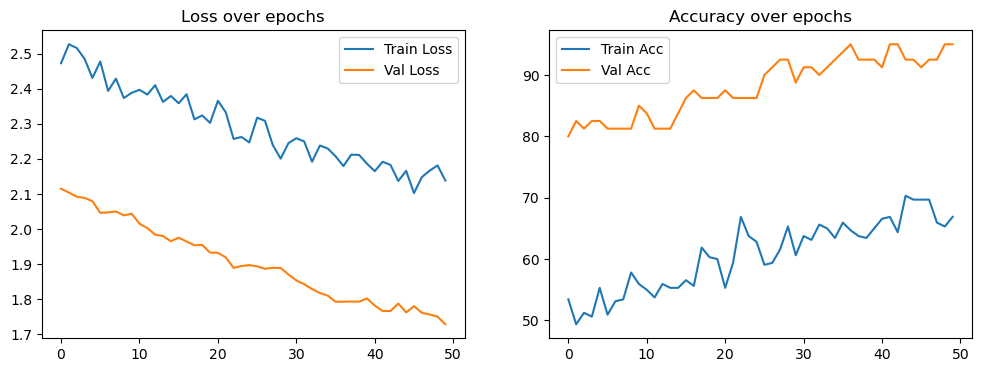

In [115]:
# Tracé des courbes
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss over epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.title('Accuracy over epochs')
plt.legend()
plt.show()

**Test**

In [118]:
from PIL import Image

def predict_and_visualize(model, image_path, transform, class_names):

    model.eval()
    
    # Charger et transformer l'image
    image = Image.open(image_path).convert('RGB')
    image_transformed = transform(image).unsqueeze(0)  # Ajouter la dimension batch

    # Prédiction
    with torch.no_grad():
        output = model(image_transformed)
        _, predicted = torch.max(output.data, 1)
        predicted_class = class_names[predicted.item()]
    
    # Affichage
    plt.imshow(np.asarray(image))
    plt.title(f"Prédiction : {predicted_class}", fontsize=16)
    plt.axis('off')
    plt.show()


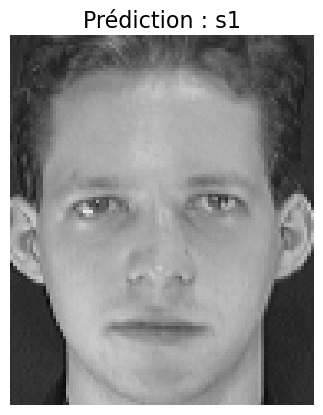

In [120]:
# Exemple d'image à tester (à adapter à ton dataset)
image_path = "C:/Users/user/Deep Learning/faces/s1/1.pgm"  

# Utiliser le modèle final ou le modèle entraîné
predict_and_visualize(model, image_path, transform, dataset.classes)


#Bonne prediction